In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# read the file

In [3]:
local_path = "../data/Txs_LoteriaBlacksmith.xlsx"
df = pd.read_excel(local_path)

# EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99789 entries, 0 to 99788
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   IdCliente    99769 non-null  float64       
 1   Genero       99789 non-null  object        
 2   CodOficina   99789 non-null  int64         
 3   CodSDV       99789 non-null  int64         
 4   CodCanal     99789 non-null  int64         
 5   CodProducto  99789 non-null  object        
 6   NomProducto  99789 non-null  object        
 7   FechaTx      99789 non-null  datetime64[ns]
 8   HoraTx       99789 non-null  int64         
 9   Cantidad     99789 non-null  int64         
 10   Ingreso     99789 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 8.4+ MB


In [6]:
# Lista de nombres de columnas a convertir a categorías
columnas_a_convertir = ['IdCliente', 'CodOficina', 'CodSDV', 'CodCanal']

# Convertir las columnas a categorías
df[columnas_a_convertir] = df[columnas_a_convertir].astype('str')

In [7]:
# Filtrar las columnas numéricas
columnas_numericas = df.select_dtypes(include='number')
columnas_numericas.describe()

,HoraTx,Cantidad,Ingreso
count,99789.000000,99789.000000,99789.000000
mean,14.268577,2.541352,9763.130205
std,3.915750,2.724239,12231.076464
min,0.000000,1.000000,2000.000000
25%,11.000000,1.000000,3000.000000
50%,15.000000,2.000000,6000.000000
75%,17.000000,3.000000,12000.000000
max,23.000000,50.000000,285000.000000


In [8]:
# Filtrar las columnas categóricas
columnas_categoricas = df.select_dtypes(include='object')
columnas_categoricas.describe()

,IdCliente,Genero,CodOficina,CodSDV,CodCanal,CodProducto,NomProducto
count,99789,99789,99789,99789,99789,99789,99789
unique,24810,3,221,2508,5,1,1
top,166177.0,M,2936801,109216,1,P551,LOTERIA BLACKSMITH
freq,2738,50015,5886,2711,76353,99789,99789


In [9]:
df_sel = df.drop(['IdCliente','NomProducto','CodProducto'],axis=1)

## seleccionar los 25 codigos de sitios de venta que mas cantidades venden

In [10]:
df_sdv_top =df_sel.groupby(by='CodSDV', sort=True)['Cantidad'].sum().sort_values(ascending=False).head(25).reset_index()
df_sdv_top.head(5)
df_sdv_top.to_csv('top_cod_sdv.csv')

In [13]:
list_cod_sdv= list(df_sdv_top['CodSDV'].unique())
list_cod_sdv[0]

'109216'

In [10]:
df_by_sdv = df_sel[df_sel['CodSDV']==list_cod_sdv[0]]
columnas_agrupar = ['Cod SDV','FechaTx']
columna_sumar = ['Cantidad']
df_by_sdv = df_by_sdv.groupby(by=columnas_agrupar)[columna_sumar].sum().reset_index()[['FechaTx','Cantidad']]
df_by_sdv

,Fecha Tx,Cantidad
0,2022-08-16,2
1,2022-08-17,1
2,2022-08-18,4
3,2022-08-19,1
4,2022-08-26,1
...,...,...
275,2023-07-10,14
276,2023-07-11,43
277,2023-07-12,17
278,2023-07-13,31


In [11]:
import holidays_co
# Convertir la columna "Fecha Tx" a tipo datetime si no lo está
df_by_sdv['FechaTx'] = pd.to_datetime(df_by_sdv['FechaTx'])


# Establecer la columna "Fecha Tx" como índice del DataFrame
df_by_sdv = df_by_sdv.set_index('FechaTx')


# Generar un rango de fechas desde la primera hasta la última fecha en el DataFrame
rango_fechas = pd.date_range(start=df_by_sdv.index.min(), end=df_by_sdv.index.max(), freq='D')

# Reindexar el DataFrame con el rango de fechas generado
df_by_sdv = df_by_sdv.reindex(rango_fechas, fill_value=0)

df_by_sdv = df_by_sdv.reset_index()

# Agregar la columna de día de la semana en formato numérico (Lunes = 0, Domingo = 6)
df_by_sdv['DiaSemana'] = df_by_sdv['index'].dt.weekday

# Agregar la columna de mes en formato numérico
df_by_sdv['Mes'] = df_by_sdv['index'].dt.month

# Agregar la columna de mes en formato numérico
df_by_sdv['Dia'] = df_by_sdv['index'].dt.day

# quincena
quincena =[15,30,31]
df_by_sdv['EsQuincena'] = df_by_sdv['Dia'].map(lambda x: x in quincena)

# Agregar la columna de festivo o día laboral
df_by_sdv['EsFestivo'] = df_by_sdv['index'].map(lambda x: holidays_co.is_holiday_date(x))

# Establecer la columna "Fecha Tx" como índice del DataFrame
df_by_sdv = df_by_sdv.set_index('index')

df_by_sdv['media_movil'] = df_by_sdv['Cantidad'].rolling(window=7).mean()


df_by_sdv.head(15)

,Cantidad,DiaSemana,Mes,Dia,EsQuincena,EsFestivo,media_movil
index,,,,,,,
2022-08-16,2,1,8,16,False,False,NaN
2022-08-17,1,2,8,17,False,False,NaN
2022-08-18,4,3,8,18,False,False,NaN
2022-08-19,1,4,8,19,False,False,NaN
2022-08-20,0,5,8,20,False,False,NaN
2022-08-21,0,6,8,21,False,False,NaN
2022-08-22,0,0,8,22,False,False,1.142857
2022-08-23,0,1,8,23,False,False,0.857143
2022-08-24,0,2,8,24,False,False,0.714286


In [12]:
df_by_sdv['media_movil'] = df_by_sdv['media_movil'].shift(1)
df_by_sdv.head(15)

,Cantidad,DiaSemana,Mes,Dia,EsQuincena,EsFestivo,media_movil
index,,,,,,,
2022-08-16,2,1,8,16,False,False,NaN
2022-08-17,1,2,8,17,False,False,NaN
2022-08-18,4,3,8,18,False,False,NaN
2022-08-19,1,4,8,19,False,False,NaN
2022-08-20,0,5,8,20,False,False,NaN
2022-08-21,0,6,8,21,False,False,NaN
2022-08-22,0,0,8,22,False,False,NaN
2022-08-23,0,1,8,23,False,False,1.142857
2022-08-24,0,2,8,24,False,False,0.857143


<Axes: xlabel='index'>

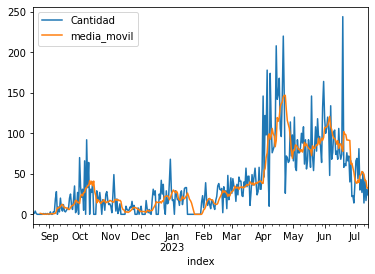

In [13]:
df_by_sdv[['Cantidad','media_movil']].plot()

In [14]:
data_sel = df_by_sdv.columns[:]
data = df_by_sdv[data_sel]
data = data.asfreq('d')
data = data.sort_index()
data.tail(15)

,Cantidad,DiaSemana,Mes,Dia,EsQuincena,EsFestivo,media_movil
index,,,,,,,
2023-06-30,14,4,6,30,True,False,52.142857
2023-07-01,37,5,7,1,False,False,43.285714
2023-07-02,66,6,7,2,False,False,39.142857
2023-07-03,69,0,7,3,False,True,38.285714
2023-07-04,44,1,7,4,False,False,42.428571
2023-07-05,81,2,7,5,False,False,39.285714
2023-07-06,30,3,7,6,False,False,47.714286
2023-07-07,43,4,7,7,False,False,48.714286
2023-07-08,27,5,7,8,False,False,52.857143


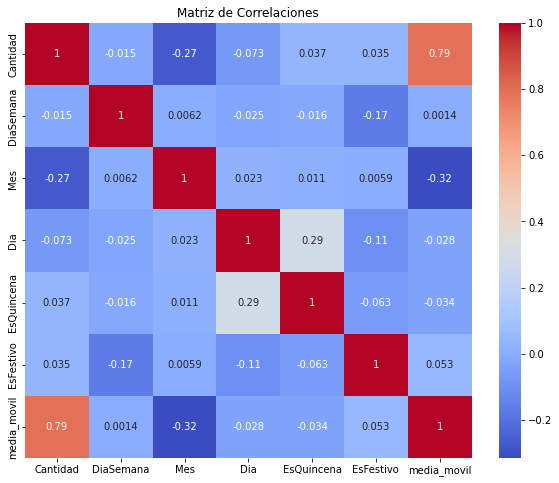

In [15]:
# Supongamos que tienes un DataFrame llamado 'df' con las variables a analizar

# Calcular la matriz de correlaciones
correlation_matrix = data.corr() #pearson

# Crear el mapa de calor de la matriz de correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

# Configurar el título del gráfico
plt.title("Matriz de Correlaciones")

# Mostrar el gráfico
plt.show()

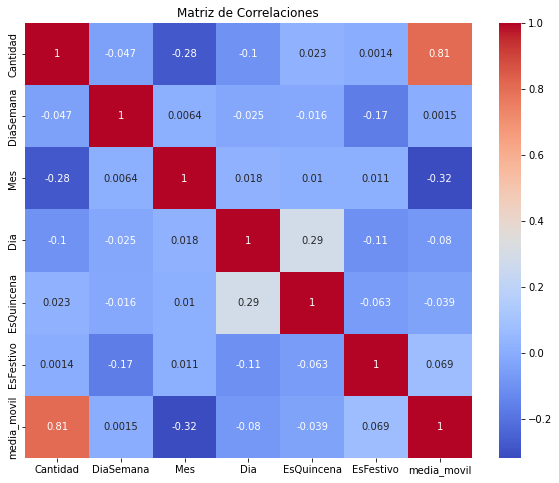

In [16]:
# Supongamos que tienes un DataFrame llamado 'df' con las variables a analizar

# Calcular la matriz de correlaciones
correlation_matrix = data.corr(method='spearman')

# Crear el mapa de calor de la matriz de correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

# Configurar el título del gráfico
plt.title("Matriz de Correlaciones")

# Mostrar el gráfico
plt.show()

In [17]:

# Libraries
# ==============================================================================

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

c:\repos\prueba-loteria-blacksmith\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


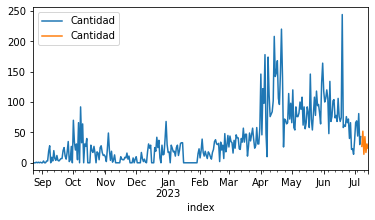

In [18]:
# Split train-test
# ==============================================================================
y = 'Cantidad'
steps = 7
sel_exog = ['Mes', 'Dia','media_movil']#, 'DiaSemana','EsQuincena', 'EsFestivo']
data_train = data[:-steps].dropna()
data_test  = data[-steps:]
# Lags used as predictors
lags_grid = [7, 21, 60]#[7, 14, 21, 30, 60]

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_train[[y]].plot(ax=ax, label='train')
data_test[[y]].plot(ax=ax, label='test')
ax.legend()

In [19]:

# Prediction error
# ==============================================================================

mse = mean_squared_error(
                y_true = data_test[y],
                y_pred = data_test['media_movil']
            )
mape = mean_absolute_percentage_error(
                y_true = data_test[y],
                y_pred = data_test['media_movil']
            )
r2 = r2_score(
                y_true = data_test[y],
                y_pred = data_test['media_movil']
            )
            
print(f"Test error (mse): {mse} mape: {mape} r2: {r2}")

Test error (mse): 370.798833819242 mape: 0.7660193893436252 r2: -1.3104199970934456


In [20]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer# Create and fit forecaster with different transformer for each exog variable
# ==============================================================================
transformer_exog = ColumnTransformer(
                       [#('scale_1', OneHotEncoder(), ['DiaSemana']),
                        ('scale_2', MinMaxScaler(), ['Mes']),
                        ('scale_3', MinMaxScaler(), ['Dia']),
                        ('scale_4', MinMaxScaler(), ['media_movil']),
                        #('onehot_1', OneHotEncoder(), ['EsFestivo']),
                        #('onehot_2', OneHotEncoder(), ['EsQuincena'])
                       ],
                       remainder = 'drop', #passthrough',
                       verbose_feature_names_out = False
                   )

In [21]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 14,
                 transformer_y = MinMaxScaler(),
                 transformer_exog= transformer_exog
             )

forecaster.fit(y=data_train[y],exog=data_train[sel_exog])
forecaster

ForecasterAutoreg 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for y: MinMaxScaler() 
Transformer for exog: ColumnTransformer(transformers=[('scale_2', MinMaxScaler(), ['Mes']),
                                ('scale_3', MinMaxScaler(), ['Dia']),
                                ('scale_4', MinMaxScaler(), ['media_movil'])],
                  verbose_feature_names_out=False) 
Window size: 14 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['Mes', 'Dia', 'media_movil'] 
Training range: [Timestamp('2022-08-23 00:00:00'), Timestamp('2023-07-07 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-07-17 00:5

In [22]:
# Predict
# ==============================================================================
# Predict only a subset of steps
predictions = forecaster.predict(steps=steps, exog=data_test[sel_exog])
display(predictions)

2023-07-08    52.294766
2023-07-09    58.252832
2023-07-10    51.804315
2023-07-11    49.901146
2023-07-12    43.730387
2023-07-13    45.722400
2023-07-14    43.289610
Freq: D, Name: pred, dtype: float64

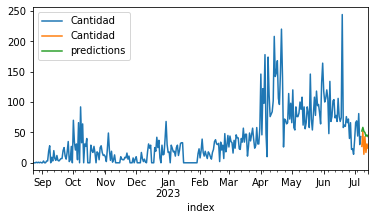

In [23]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_train[[y]].plot(ax=ax, label='train')
data_test[[y]].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [24]:
# Prediction error
# ==============================================================================

mse = mean_squared_error(
                y_true = data_test[y],
                y_pred = predictions
            )
mape = mean_absolute_percentage_error(
                y_true = data_test[y],
                y_pred = predictions
            )
r2 = r2_score(
                y_true = data_test[y],
                y_pred = predictions
            )
            
print(f"Test error (mse): {mse} mape: {mape} r2: {r2}")

Test error (mse): 494.1524033961735 mape: 0.9669879273295547 r2: -2.0790269285875507


In [25]:
# Hyperparameter grid search using a scikit-learn pipeline
# ==============================================================================
pipe = make_pipeline(MinMaxScaler(), Ridge(random_state=123))
forecaster = ForecasterAutoreg(
                 regressor = pipe,
                 lags = 10,  # This value will be replaced in the grid search
                 transformer_exog= transformer_exog
             )

# Regressor's hyperparameters
param_grid = {'ridge__alpha': np.logspace(-3, 5, 10)}


results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data_train[y],
                   exog               = data_train[sel_exog],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = steps,
                   metric             = ['mean_absolute_error','mean_squared_error'],
                   refit              = False,
                   initial_train_size = int(len(data_train)*0.9),
                   fixed_train_size   = True,
                   return_best        = True,
                   verbose            = False,
                   show_progress      = True
               )

results_grid.head(4)

Number of models compared: 30.


lags grid: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'ridge__alpha': 27.825594022071257}
  Backtesting metric: 23.94499273796206



,lags,params,mean_absolute_error,mean_squared_error,ridge__alpha
5,"[1, 2, 3, 4, 5, 6, 7]",{'ridge__alpha': 27.825594022071257},23.944993,1575.273644,27.825594
26,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 215.44346900318823},24.011016,1532.440181,215.443469
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 215.44346900318823},24.293202,1660.061338,215.443469
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 27.825594022071257},27.710774,1540.034018,27.825594


In [26]:
# Predict
# ==============================================================================
# Predict only a subset of steps
predictions = forecaster.predict(steps=steps, exog=data_test[sel_exog])
display(predictions)

2023-07-08    49.047438
2023-07-09    50.101424
2023-07-10    47.757120
2023-07-11    45.328449
2023-07-12    45.264796
2023-07-13    41.167730
2023-07-14    41.709501
Freq: D, Name: pred, dtype: float64

In [27]:
# Prediction error
# ==============================================================================

mse = mean_squared_error(
                y_true = data_test[y],
                y_pred = predictions
            )
mape = mean_absolute_percentage_error(
                y_true = data_test[y],
                y_pred = predictions
            )
r2 = r2_score(
                y_true = data_test[y],
                y_pred = predictions
            )
            
print(f"Test error (mse): {mse} mape: {mape} r2: {r2}")

Test error (mse): 407.2238300389229 mape: 0.8638539892819926 r2: -1.537381443528385


In [28]:
# Hyperparameter grid search using a scikit-learn pipeline
# ==============================================================================
pipe = make_pipeline(MinMaxScaler(), XGBRegressor(random_state = 123))
forecaster = ForecasterAutoreg(
                 regressor = pipe,
                 lags = 10,  # This value will be replaced in the grid search
                 transformer_exog= transformer_exog
             )

# Regressor's hyperparameters

param_grid = {
        'xgbregressor__min_child_weight': [1,5],#[1, 5, 10],
        'xgbregressor__gamma': [0.5,1,2], #[0.5, 1, 1.5, 2, 5],
        'xgbregressor__subsample': [0.6],#[0.6, 0.8, 1.0],
        'xgbregressor__colsample_bytree': [0.6],#[0.6, 0.8, 1.0],
        'xgbregressor__max_depth': [3,5]#[3, 4, 5]
        }


results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data_train[y],
                   exog               = data_train[sel_exog],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = steps,
                   metric             = ['mean_absolute_error','mean_squared_error'],
                   refit              = False,
                   initial_train_size = int(len(data_train)*0.8),
                   fixed_train_size   = True,
                   return_best        = True,
                   verbose            = False,
                   show_progress      = True
               )

results_grid.head(4)

Number of models compared: 36.


lags grid: 100%|██████████| 3/3 [00:15<00:00,  5.28s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60] 
  Parameters: {'xgbregressor__colsample_bytree': 0.6, 'xgbregressor__gamma': 2, 'xgbregressor__max_depth': 5, 'xgbregressor__min_child_weight': 1, 'xgbregressor__subsample': 0.6}
  Backtesting metric: 27.93964198231697



,lags,params,mean_absolute_error,mean_squared_error,xgbregressor__colsample_bytree,xgbregressor__gamma,xgbregressor__max_depth,xgbregressor__min_child_weight,xgbregressor__subsample
34,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'xgbregressor__colsample_bytree': 0.6, 'xgbre...",27.939642,1526.450673,0.6,2.0,5.0,1.0,0.6
30,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'xgbregressor__colsample_bytree': 0.6, 'xgbre...",28.351781,1608.229055,0.6,1.0,5.0,1.0,0.6
31,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'xgbregressor__colsample_bytree': 0.6, 'xgbre...",28.908394,1619.981015,0.6,1.0,5.0,5.0,0.6
27,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'xgbregressor__colsample_bytree': 0.6, 'xgbre...",29.172681,1673.651848,0.6,0.5,5.0,5.0,0.6


In [29]:
# Predict
# ==============================================================================
# Predict only a subset of steps
predictions = forecaster.predict(steps=steps, exog=data_test[sel_exog])
display(predictions)

2023-07-08    74.836365
2023-07-09    40.644043
2023-07-10    44.943596
2023-07-11    47.459869
2023-07-12    35.542248
2023-07-13    71.572594
2023-07-14    48.715488
Freq: D, Name: pred, dtype: float64

In [30]:
# Prediction error
# ==============================================================================

mse = mean_squared_error(
                y_true = data_test[y],
                y_pred = predictions
            )
mape = mean_absolute_percentage_error(
                y_true = data_test[y],
                y_pred = predictions
            )
r2 = r2_score(
                y_true = data_test[y],
                y_pred = predictions
            )
            
print(f"Test error (mse): {mse} mape: {mape} r2: {r2}")

Test error (mse): 856.4968275908157 mape: 1.104771651948191 r2: -4.336768127155387


In [31]:
# Libraries
# ======================================================================================
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from pmdarima import ARIMA
from sklearn.metrics import mean_absolute_error
import itertools
import warnings
warnings.filterwarnings('ignore')

In [32]:
from sklearn.neural_network import MLPRegressor
# Hyperparameter grid search using a scikit-learn pipeline
# ==============================================================================
pipe = make_pipeline(MinMaxScaler(), MLPRegressor(random_state=123, max_iter=500))
forecaster = ForecasterAutoreg(
                 regressor = pipe,
                 lags = 10,  # This value will be replaced in the grid search
                 transformer_exog= transformer_exog
             )

In [33]:
param_grid = {
          'mlpregressor__hidden_layer_sizes': [(50,1), (100,1),(50,50), (100,100)],
          'mlpregressor__activation': ['relu','tanh','logistic'],
          'mlpregressor__alpha': [0.0001, 0.05],
          'mlpregressor__learning_rate': ['constant','adaptive'],
          'mlpregressor__solver': ['adam']}

# Lags used as predictors
lags_grid = [7, 14, 21, 30, 60]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data_train[y],
                   exog               = data_train[sel_exog],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = steps,
                   metric             = ['mean_absolute_error','mean_squared_error'],
                   refit              = False,
                   initial_train_size = int(len(data)*0.8),
                   fixed_train_size   = True,
                   return_best        = True,
                   verbose            = False,
                   show_progress      = True
               )

results_grid.head(4)

Number of models compared: 240.


lags grid: 100%|██████████| 5/5 [06:10<00:00, 74.14s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'mlpregressor__activation': 'tanh', 'mlpregressor__alpha': 0.05, 'mlpregressor__hidden_layer_sizes': (100, 100), 'mlpregressor__learning_rate': 'constant', 'mlpregressor__solver': 'adam'}
  Backtesting metric: 25.67939859765771



,lags,params,mean_absolute_error,mean_squared_error,mlpregressor__activation,mlpregressor__alpha,mlpregressor__hidden_layer_sizes,mlpregressor__learning_rate,mlpregressor__solver
30,"[1, 2, 3, 4, 5, 6, 7]","{'mlpregressor__activation': 'tanh', 'mlpregre...",25.679399,1337.380401,tanh,0.0500,"(100, 100)",constant,adam
31,"[1, 2, 3, 4, 5, 6, 7]","{'mlpregressor__activation': 'tanh', 'mlpregre...",25.679399,1337.380401,tanh,0.0500,"(100, 100)",adaptive,adam
23,"[1, 2, 3, 4, 5, 6, 7]","{'mlpregressor__activation': 'tanh', 'mlpregre...",25.683598,1337.557851,tanh,0.0001,"(100, 100)",adaptive,adam
22,"[1, 2, 3, 4, 5, 6, 7]","{'mlpregressor__activation': 'tanh', 'mlpregre...",25.683598,1337.557851,tanh,0.0001,"(100, 100)",constant,adam


In [34]:
# Predict
# ==============================================================================
# Predict only a subset of steps
predictions = forecaster.predict(steps=steps, exog=data_test[sel_exog])#, exog=data_test[['DiaSemana','Mes','EsFestivo']])
display(predictions)

2023-07-08    48.132720
2023-07-09    74.589824
2023-07-10    69.807310
2023-07-11    75.096814
2023-07-12    75.139985
2023-07-13    63.385198
2023-07-14    62.112136
Freq: D, Name: pred, dtype: float64

In [35]:
# Prediction error
# ==============================================================================

mse = mean_squared_error(
                y_true = data_test[y],
                y_pred = predictions
            )
mape = mean_absolute_percentage_error(
                y_true = data_test[y],
                y_pred = predictions
            )
r2 = r2_score(
                y_true = data_test[y],
                y_pred = predictions
            )
            
print(f"Test error (mse): {mse} mape: {mape} r2: {r2}")

Test error (mse): 1569.0210299504647 mape: 1.7146393742473356 r2: -8.776453518256963


In [36]:
# Valores iniciales
p_inicial = 7
d_inicial = 0
q_inicial = 0

# Valores finales
p_final = 14
d_final = 4
q_final = 4

# Generar todas las combinaciones posibles de p, d y q
combinaciones = itertools.product(range(p_inicial, p_final + 1,4),
                                  range(d_inicial, d_final + 1,1),
                                  range(q_inicial, q_final + 1,1))

# Convertir las combinaciones en una lista de duplas
duplas = list(combinaciones)
len(duplas)

50

In [37]:
# Grid search hyperparameter
# ======================================================================================
forecaster = ForecasterSarimax(
                 regressor=ARIMA(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
                 transformer_exog= None
             )

param_grid = {
    'order': [(7,0,0),(7,1,0),(7,1,1),(7,0,7),(7,1,7),
              (14,0,0),(14,1,0),(14,1,1),(14,0,7),(14,1,7),
              (21,0,0),(21,1,0),(21,1,1),(21,0,7),(21,1,7)],
    'seasonal_order': [(0, 0, 0, 0)],
    'trend': [None, 'n', 'c']
}

results_grid = grid_search_sarimax(
                   forecaster         = forecaster,
                   y                  = data_train[y],
                   #exog               = data_train[['DiaSemana','Mes','EsFestivo']],
                   param_grid         = param_grid,
                   steps              = steps,
                   refit              = True,
                   metric             = 'mean_absolute_error',
                   initial_train_size = int(len(data_train)*0.5),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = -1,
                   verbose            = False,
                   show_progress      = True
               )

results_grid.head(5)

Number of models compared: 45.


params grid: 100%|██████████| 45/45 [26:29<00:00, 35.33s/it] 

`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (7, 1, 0), 'seasonal_order': (0, 0, 0, 0), 'trend': 'n'}
  Backtesting metric: 24.965058136559488



,params,mean_absolute_error,order,seasonal_order,trend
4,"{'order': (7, 1, 0), 'seasonal_order': (0, 0, ...",24.965058,"(7, 1, 0)","(0, 0, 0, 0)",n
3,"{'order': (7, 1, 0), 'seasonal_order': (0, 0, ...",25.150415,"(7, 1, 0)","(0, 0, 0, 0)",None
5,"{'order': (7, 1, 0), 'seasonal_order': (0, 0, ...",25.150415,"(7, 1, 0)","(0, 0, 0, 0)",c
1,"{'order': (7, 0, 0), 'seasonal_order': (0, 0, ...",25.250723,"(7, 0, 0)","(0, 0, 0, 0)",n
0,"{'order': (7, 0, 0), 'seasonal_order': (0, 0, ...",25.275612,"(7, 0, 0)","(0, 0, 0, 0)",None


In [38]:
# Predict
# ==============================================================================
# Predict only a subset of steps
predictions = forecaster.predict(steps=steps)#, exog=data_test[['DiaSemana','Mes','EsFestivo']])
display(predictions)

2023-07-08    45.177098
2023-07-09    54.468909
2023-07-10    48.465054
2023-07-11    53.028421
2023-07-12    49.590137
2023-07-13    52.208592
2023-07-14    47.027650
Freq: D, Name: pred, dtype: float64

In [39]:
# Prediction error
# ==============================================================================

mse = mean_squared_error(
                y_true = data_test[y],
                y_pred = predictions
            )
mape = mean_absolute_percentage_error(
                y_true = data_test[y],
                y_pred = predictions
            )
r2 = r2_score(
                y_true = data_test[y],
                y_pred = predictions
            )
            
print(f"Test error (mse): {mse} mape: {mape} r2: {r2}")

Test error (mse): 523.8722326017972 mape: 0.9966305626393277 r2: -2.2642089773001097


In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_test[[y]].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();